# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from StimulusnResponse import expSnR

importing Jupyter notebook from StimulusnResponse.ipynb


In [3]:
def NGD2L_TK(T, alpha, beta, gamma, g, h, l, tau_y, Amp):
    dt = np.mean(np.diff(T))
    dt = 0.1*dt
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    y=np.zeros_like(x)
    z=np.zeros_like(x)
    w=np.zeros_like(x)
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j] + x[j]-z[j] )
        dz=dt*(-beta*z[j]  + g*y[j] )
        dw=dt*(-gamma*w[j] + h*y[j]-l*z[j] )
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
        w[j+1]=w[j]+dw

    nTK = w[::10]/(dt) #normalized by integration
    return -Amp*nTK

In [4]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

In [5]:
figmap = [[np.nan, 7,15,23,31,39,47,np.nan],
          [     1, 8,16,24,32,40,48,    55],
          [     2, 9,17,25,33,41,49,    56],
          [     3,10,18,26,34,42,50,    57],
          [     4,11,19,27,35,43,51,    58],
          [     5,12,20,28,36,44,52,    59],
          [     6,13,21,29,37,45,53,    60],
          [np.nan,14,22,30,38,46,54,np.nan]]
figmap = np.array(figmap)
XOsave = True

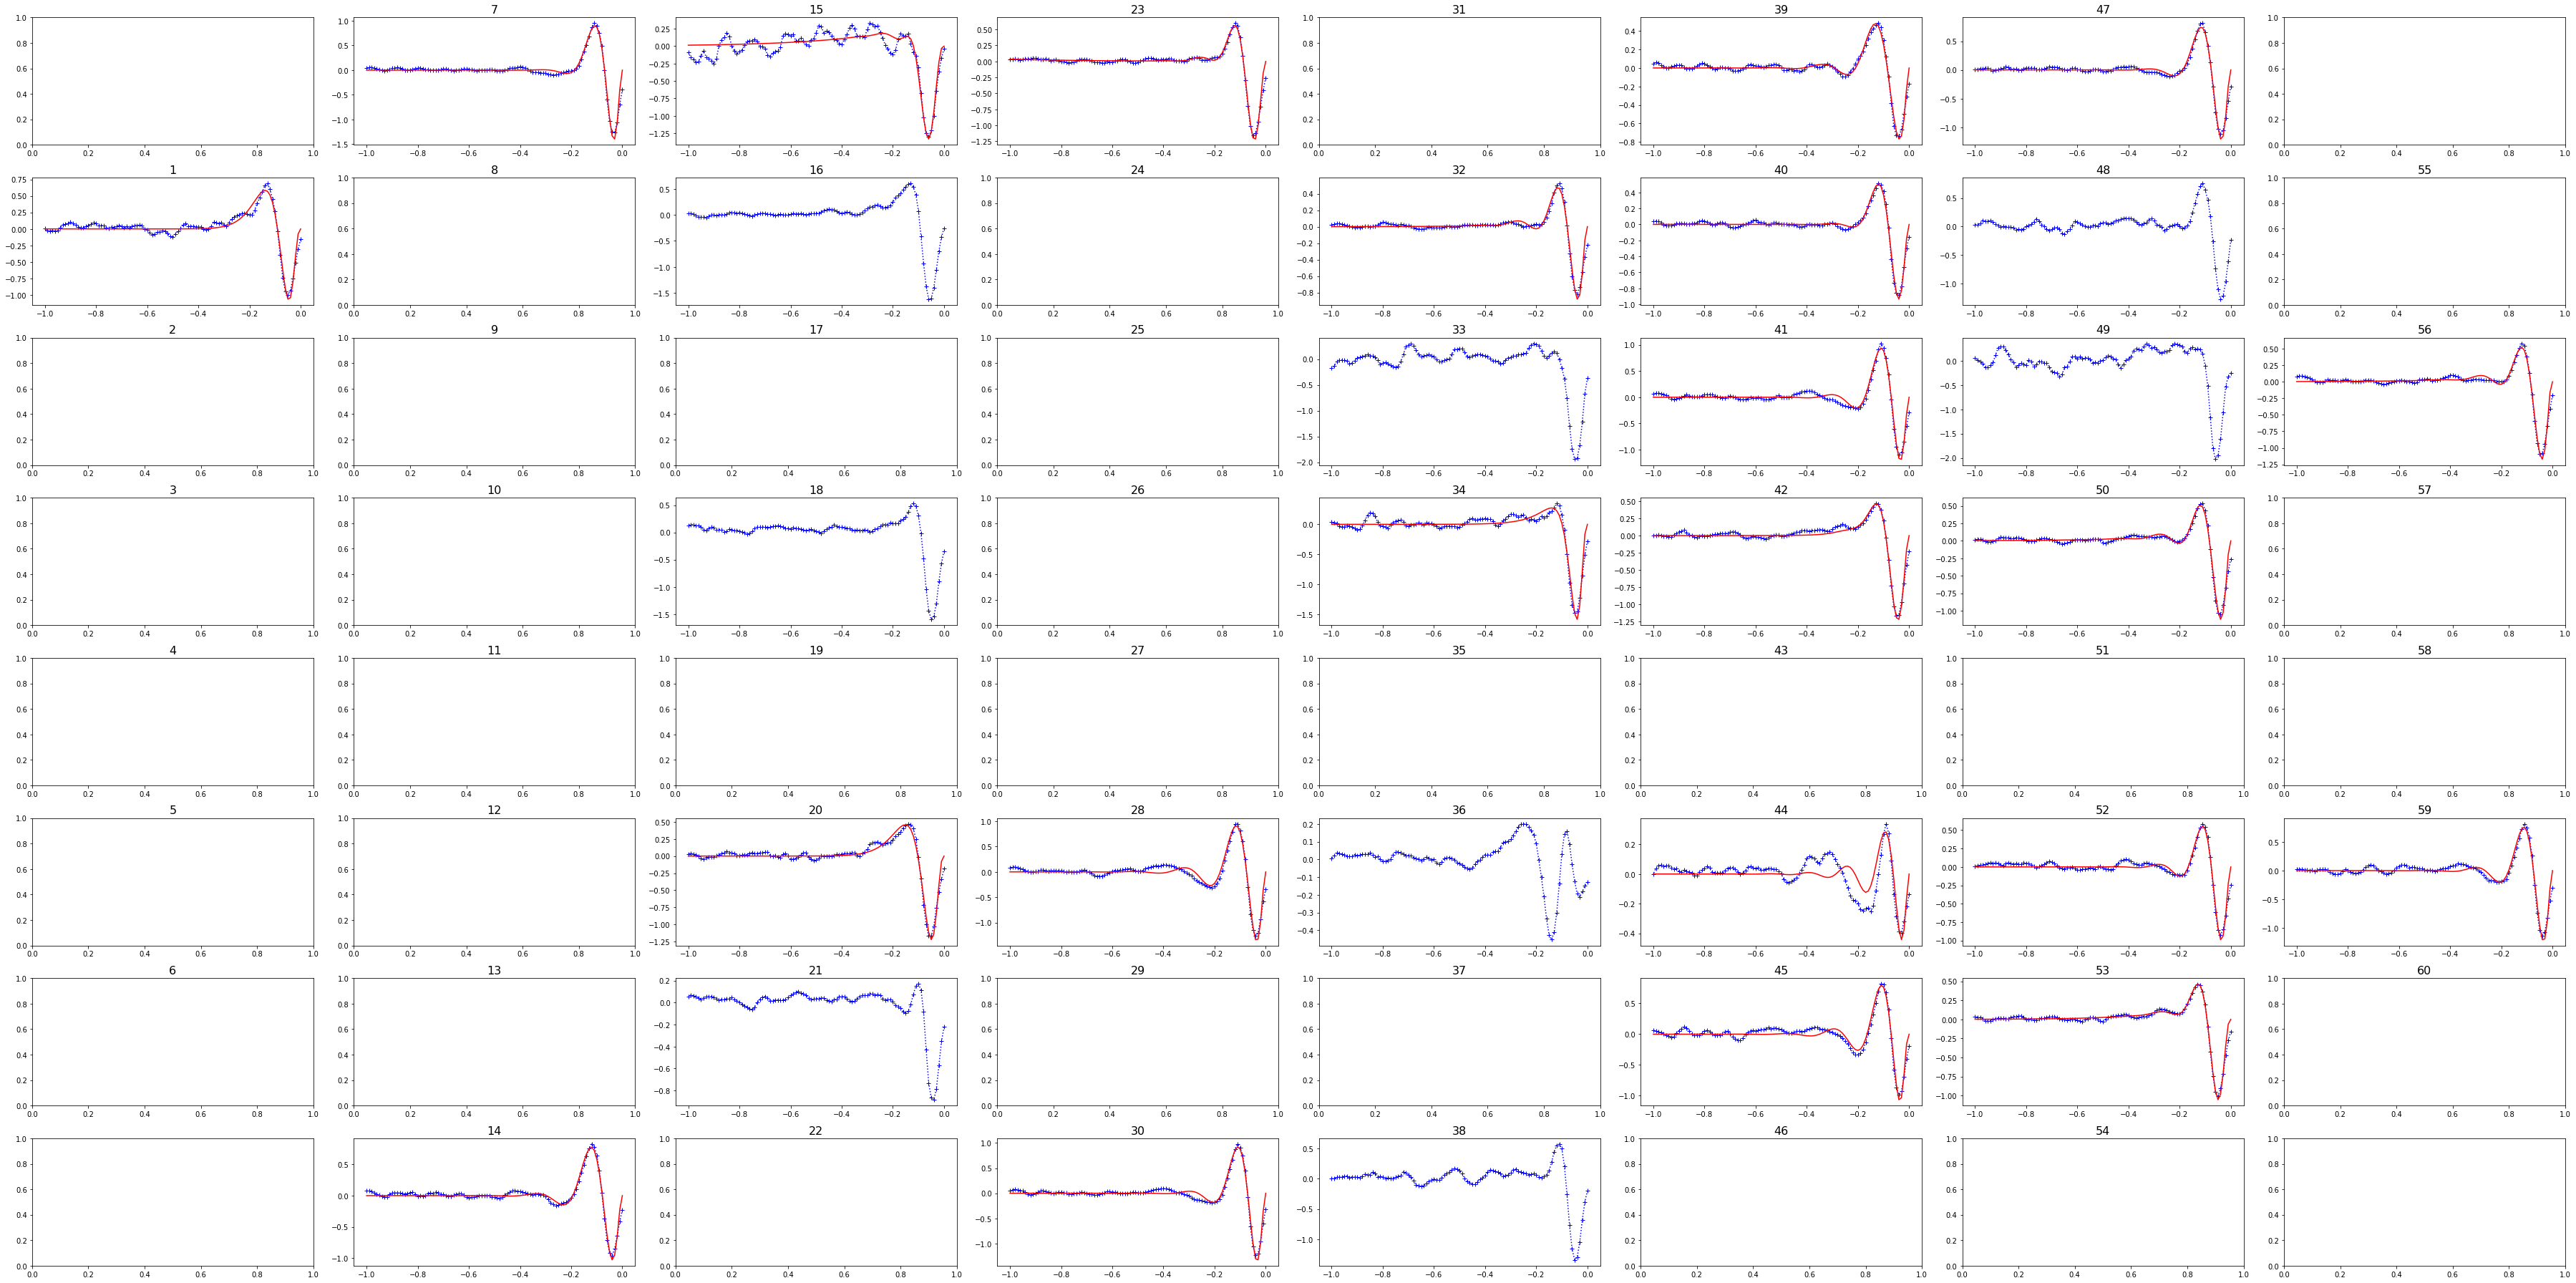

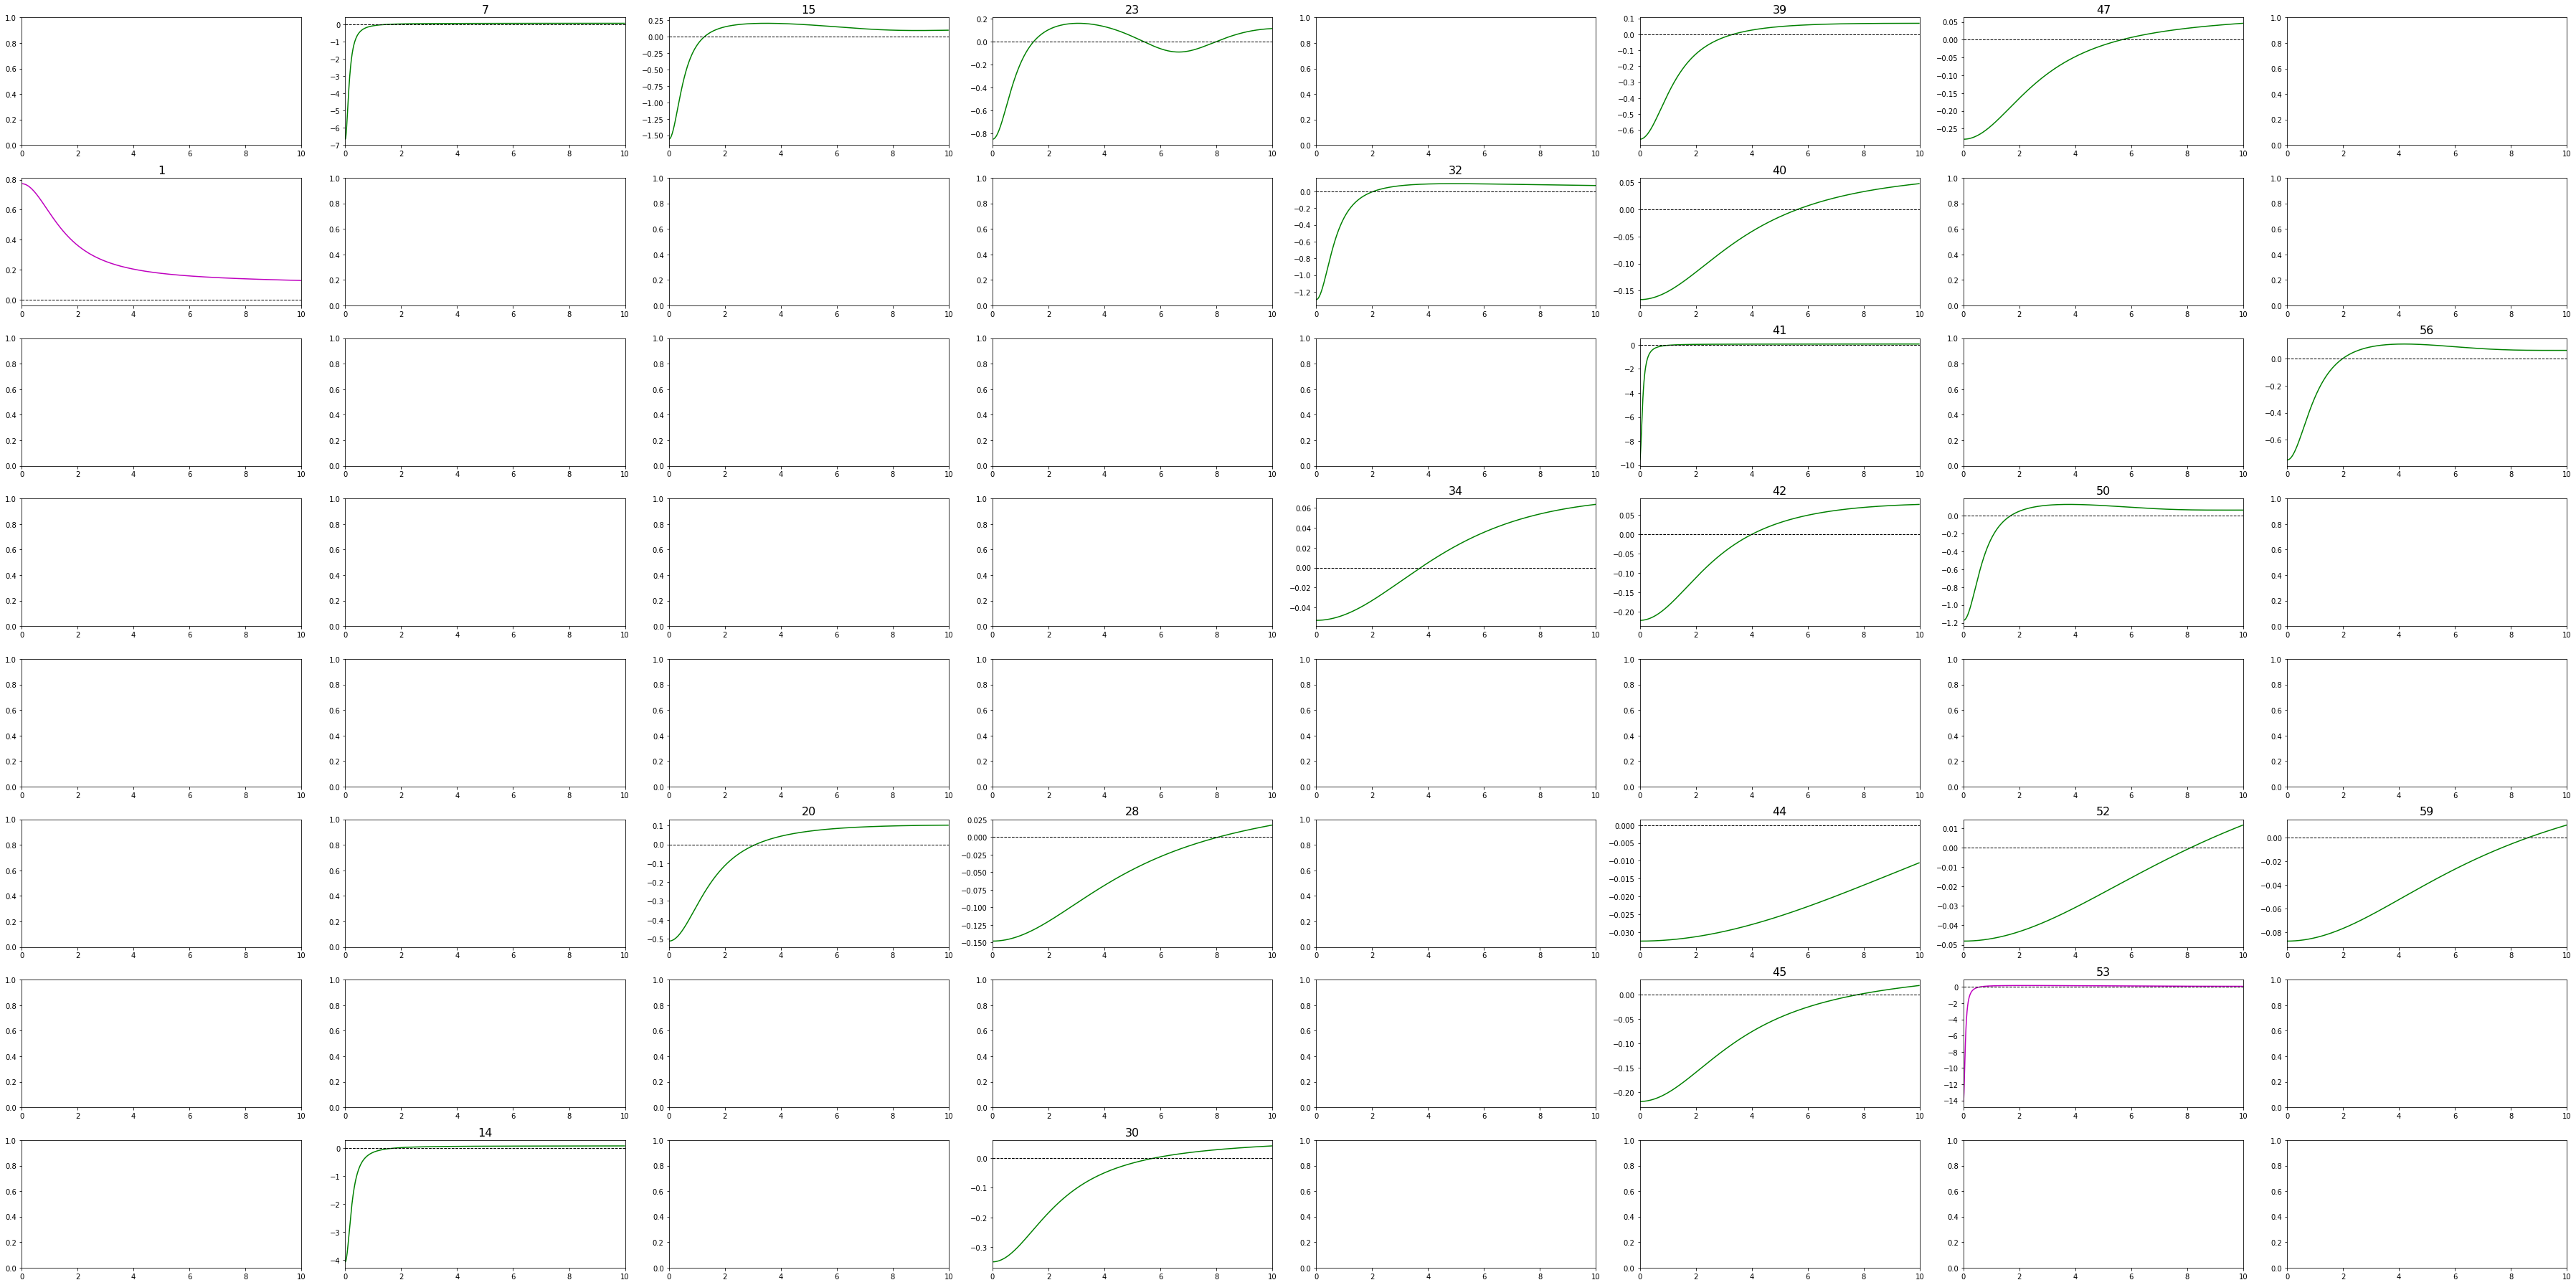

In [6]:
for exp_date in ['20200408']:
# for exp_date in ['20210504']:
    exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\'+exp_date
    filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\'+exp_date+'\\'+exp_date+'_cSTA_sort_unit2']
    dt = 0.01
    x_list, T_list, rstate_list = expSnR(filenames, dt, 'LED', np.arange(60)+1)
    x = x_list[0]
    x = x-np.mean(x)
    cSTA_list = [0]*60
    dcn = []
    fig, ax = plt.subplots(nrows=8, ncols=8)
    fig.set_size_inches(60, 30)
    for cn in range(60):
        rstate = rstate_list[0][cn,:]
        if sum(rstate) == 0: continue
        cSTA = np.correlate(x , rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
        cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
        taxis = -np.arange(len(cSTA))*dt
        if (np.abs(cSTA[:round(len(cSTA)/2)]) < 7*np.std(cSTA[round(len(cSTA)/2):-1])).all(): continue
        if sum(cSTA[:8]) < -1: dcn.append(cn) # exclude fitting of On-cell
        ax[np.where(figmap == cn+1)][0].plot(taxis, cSTA, 'b+:')
        cSTA_list[cn] = cSTA

    name_list = ['alpha', 'beta', 'gamma', 'g', 'h', 'l', 'tau_y', 'Amp']
    para_dict = {}
    for l in range(len(name_list)):
        para_dict[name_list[l]] = np.zeros(60)
    #-------------------------------------
    fit_cSTA_list = [0]*60
    para_dict['error'] = np.zeros(60)
    for cn in dcn.copy():
    #     print(cn)
        alpha = 10. #1/sec
        beta =  10.
        gamma = 42.
        g = 680
        h = 80
        i = 0.8
        tau_y = 0.07
        try:
            popt,pcov = curve_fit(NGD2L_TK, np.abs(taxis), cSTA_list[cn], p0=[alpha, beta, gamma, g, h, i, tau_y, 1],
                                  bounds = (0, [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 0.05, np.inf]))
        except:
            dcn.remove(cn)
            continue
        for l in range(len(popt)):
            para_dict[name_list[l]][cn] = popt[l]
    #     print(popt)
        fit_cSTA_list[cn] = NGD2L_TK(np.abs(taxis), *popt).copy()
        para_dict['error'][cn] = sum((fit_cSTA_list[cn]-cSTA_list[cn])**2)
        ax[np.where(figmap == cn+1)][0].plot(taxis, fit_cSTA_list[cn], 'r-')
    
    for cn in range(60):
        ax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 16)
    fig.set_size_inches(30, 15)
    fig.tight_layout()
    #-------------------------------------
    Dfig, Dax = plt.subplots(nrows=8, ncols=8)
    Dfig.set_size_inches(30, 15)
    Dfig.tight_layout()
    pcn = []
    ncn = []
    for cn in dcn:
        #constrani 1
        if sum(rstate_list[0][cn])/180 < 0.3: continue
        domega = 0.01
        omega = np.arange(-1,10,domega) #limited by [pi/dt,pi/dt)
        TKdw = np.sum(fit_cSTA_list[cn][np.newaxis,:]*np.exp(-1j*np.abs(taxis[np.newaxis,:])*omega[:,np.newaxis]), axis = 1)*dt
        phi = np.angle(TKdw)
        delta = -angular_gradient(phi)/domega
        Dax[np.where(figmap == cn+1)][0].set_title(str(cn+1), fontsize = 16)

        #constrani 2
        if delta[0] < 0: 
            pcn.append(cn)
            Dax[np.where(figmap == cn+1)][0].plot(omega[:-1], delta[:-1], 'g')
        else: 
            ncn.append(cn)
            Dax[np.where(figmap == cn+1)][0].plot(omega[:-1], delta[:-1], 'm')

    for Daxy in Dax:
        for ax in Daxy:
            ax.axhline(0,linewidth=1, linestyle='--', c='k')
            ax.set_xlim([0,10])
    #-------------------------------------
    if XOsave:
        Dfig.set_size_inches(50, 25)
        Dfig.tight_layout()
        Dfig.savefig(exp_folder+'\\TKfit\\NGD2L_GroupDelay.tiff', bbox_inches = 'tight',pad_inches = 0.3)
        np.savez(exp_folder+'\\TKfit\\fitNGD2Lpara.npz', para_dict=para_dict, pcn=pcn, ncn=ncn)
        fig.set_size_inches(50, 25)
        fig.tight_layout()
        fig.savefig(exp_folder+'\TKfit\\fitNGD2Lparameter.tiff', bbox_inches = 'tight',pad_inches = 0.3)

In [9]:
for v in para_dict.values():
    print(np.mean(v))

8.80026854001153
5.599652878997737
383.87056358744127
458.86135257422234
54.440398931451014
0.5776218135048653
0.006888345422699294
12.912340183048482
0.15103062638233786


Text(0, 0.5, '$\\beta$')

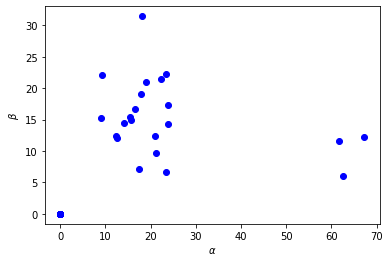

In [10]:
plt.scatter(para_dict['alpha'], para_dict['beta'], c ='b')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

Text(0, 0.5, '$\\gamma$')

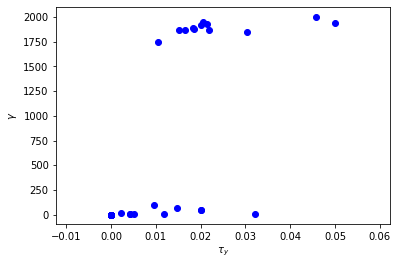

In [11]:
plt.scatter(para_dict['tau_y'], para_dict['gamma'], c ='b')
plt.xlabel(r'$\tau_y$')
plt.ylabel(r'$\gamma$')

In [8]:
import pandas as pd
pd.DataFrame(para_dict)

,alpha,beta,gamma,g,h,l,tau_y,Amp,error
0,61.781110,11.637576,48.466401,490.339756,53.400933,1.434802,0.020128,7.683237,0.466339
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,23.469086,22.201979,1952.326926,971.930996,178.178271,4.043809,0.020635,69.307132,0.413651
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
